In [1]:
#Technology Stocks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install yfinance
!pip install pyfolio
%matplotlib inline
import datetime as dt
import yfinance as yf
import pyfolio as pf
start = dt.datetime(2017,5,29).date()
end = dt.datetime(2020,6,29).date()

tickers=['TCS.NS', 'INFY.NS', 'WIPRO.NS']

DF =pd.DataFrame()

for i in tickers:
    df = yf.download(i,start,end)[['Adj Close']]
    df.columns = [i]                         
    DF = pd.concat([DF,df],axis =1)

df = DF.copy().round(5)
df.head()

C:\Users\Ravi\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TCS.NS,INFY.NS,WIPRO.NS
Date,,,
2017-05-29,1182.09790,439.29269,198.01366
2017-05-30,1172.10510,444.22006,198.58775
2017-05-31,1170.03735,435.68073,198.34700
2017-06-01,1173.25366,439.80081,200.43974
2017-06-02,1178.44519,438.91794,204.32889


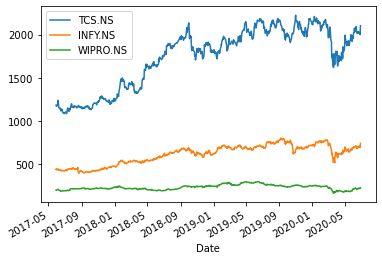

In [3]:
df = df.dropna()
df.plot()
plt.show()

In [4]:
from statsmodels.api import OLS
model = OLS(df['TCS.NS'].iloc[:90],df[['INFY.NS','WIPRO.NS']].iloc[:90])
print(model)
model = model.fit()
print(model)
print('The hedge ratio for TCS, Infosys and Wipro is')
model.params

The hedge ratio for TCS, Infosys and Wipro is


INFY.NS     1.293851
WIPRO.NS    2.881679
dtype: float64

In [5]:

df['spread'] = df['TCS.NS'] - model.params[0] * df['INFY.NS'] - model.params[1] * df['WIPRO.NS']
print(df['spread'])

Date
2017-05-29     43.106709
2017-05-30     25.084282
2017-05-31     34.758919
2017-06-01     26.613853
2017-06-02     21.740403
                 ...    
2020-06-22    483.246987
2020-06-23    461.506224
2020-06-24    483.569431
2020-06-25    475.161103
2020-06-26    495.146261
Name: spread, Length: 757, dtype: float64


The spread is: TCS - 1.293851 * INFY - 2.881679 * WIPRO


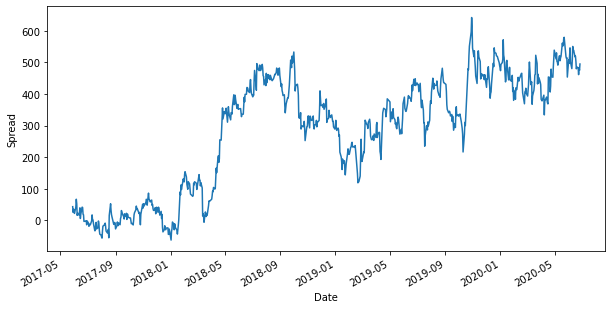

In [6]:
print('The spread is: TCS - %f * INFY - %f * WIPRO' %
      (model.params[0], model.params[1]))
# Plot the spread
df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

In [7]:
#To perform ADF Test
from statsmodels.tsa.stattools import adfuller
#Compute ADF Test statistics
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-1.9319120056410422

In [8]:
adf[4]

{'1%': -3.439029421541435,
 '5%': -2.8653706489231876,
 '10%': -2.568809835460933}

In [9]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [10]:
df = stat_arb(df, 20, 1)

In [11]:
df['percentage_change'] = (df.spread - df.spread.shift(1)) / (model.params[0] * df['INFY.NS'].shift() + model.params[1] * df['WIPRO.NS'].shift() + df['TCS.NS'].shift())
# Change in spread / cost of putting the spread yesterday
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
print("The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100))

print((df['strategy_returns'] + 1).cumprod())

The total strategy returns are 42.47
Date
2017-05-29         NaN
2017-05-30         NaN
2017-05-31         NaN
2017-06-01         NaN
2017-06-02         NaN
                ...   
2020-06-22    1.420052
2020-06-23    1.411327
2020-06-24    1.420037
2020-06-25    1.416690
2020-06-26    1.424725
Name: strategy_returns, Length: 757, dtype: float64


Text(0, 0.5, 'Cumulative Returns')

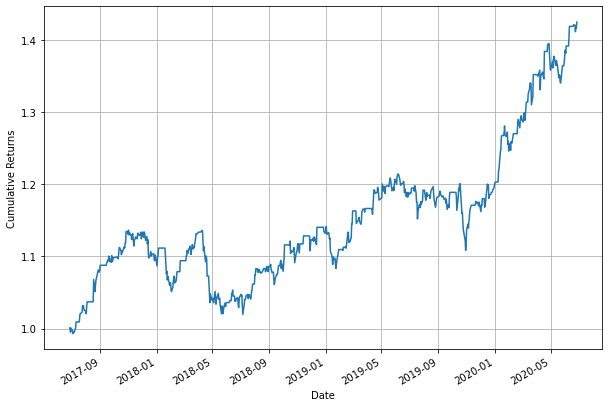

In [12]:
df['cumulative_returns'].plot(figsize=(10, 7), grid=True)
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns') 

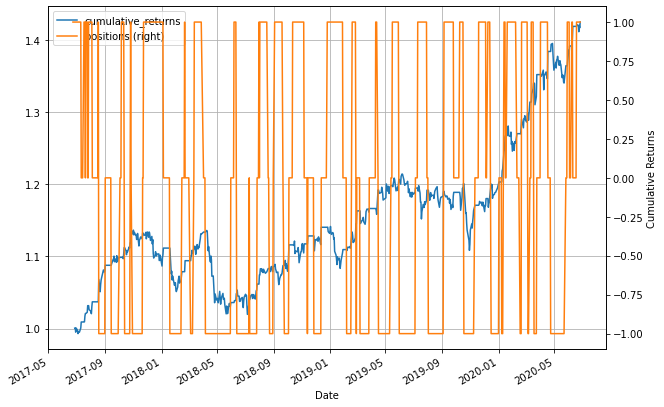

In [13]:
df[['cumulative_returns', 'positions']].plot(
        secondary_y='positions', grid=True, figsize=(10, 7))
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns') 
plt.show()

Date
2017-06-27    1.000625
2017-06-28    1.000979
2017-06-29    1.000979
2017-06-30    1.000979
2017-07-03    1.000979
                ...   
2020-06-22    1.421104
2020-06-23    1.421104
2020-06-24    1.421104
2020-06-25    1.421104
2020-06-26    1.424725
Name: cumulative_returns, Length: 737, dtype: float64
The maximum drawdown is -10.28


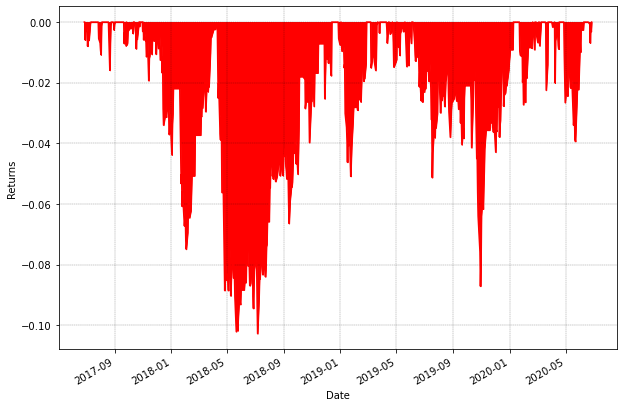

In [14]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

In [15]:
def calc_drawdown_a(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown_a =  1 - (cum_rets)/running_max
    return drawdown_a

drawdown_a = calc_drawdown_a(df.cumulative_returns)


Date
2017-06-27    1.000625
2017-06-28    1.000979
2017-06-29    1.000979
2017-06-30    1.000979
2017-07-03    1.000979
                ...   
2020-06-22    1.421104
2020-06-23    1.421104
2020-06-24    1.421104
2020-06-25    1.421104
2020-06-26    1.424725
Name: cumulative_returns, Length: 737, dtype: float64


In [16]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio is %.2f' % s

'The Sharpe Ratio is 1.21'

In [17]:
Sortino = df['strategy_returns'].mean()/df['strategy_returns'][df['strategy_returns']<0].std(ddof=1)*np.sqrt(252)
'The Sortino Ratio is %.2f' % Sortino

'The Sortino Ratio is 1.53'

In [18]:
#Average_annual_return = final_equity**(1/years)-1
df.shape[0]
years=df.shape[0]/252
print(years)

3.003968253968254


In [19]:
Average_annual_return = df['cumulative_returns'][-1]**(1/years)-1
Average_annual_return 

0.12506088781388502

In [20]:
max_drawdown = drawdown_a.max()
max_drawdown

0.10275290268412329

In [21]:
calmar = Average_annual_return / max_drawdown
'The Calmar Ratio is %.2f' % calmar

'The Calmar Ratio is 1.22'

Start date,2017-05-29
End date,2020-06-26
Total months,36
,Backtest
Annual return,12.5%
Cumulative returns,42.5%
Annual volatility,10.5%
Sharpe ratio,1.21
Calmar ratio,1.22
Stability,0.72
Max drawdown,-10.3%


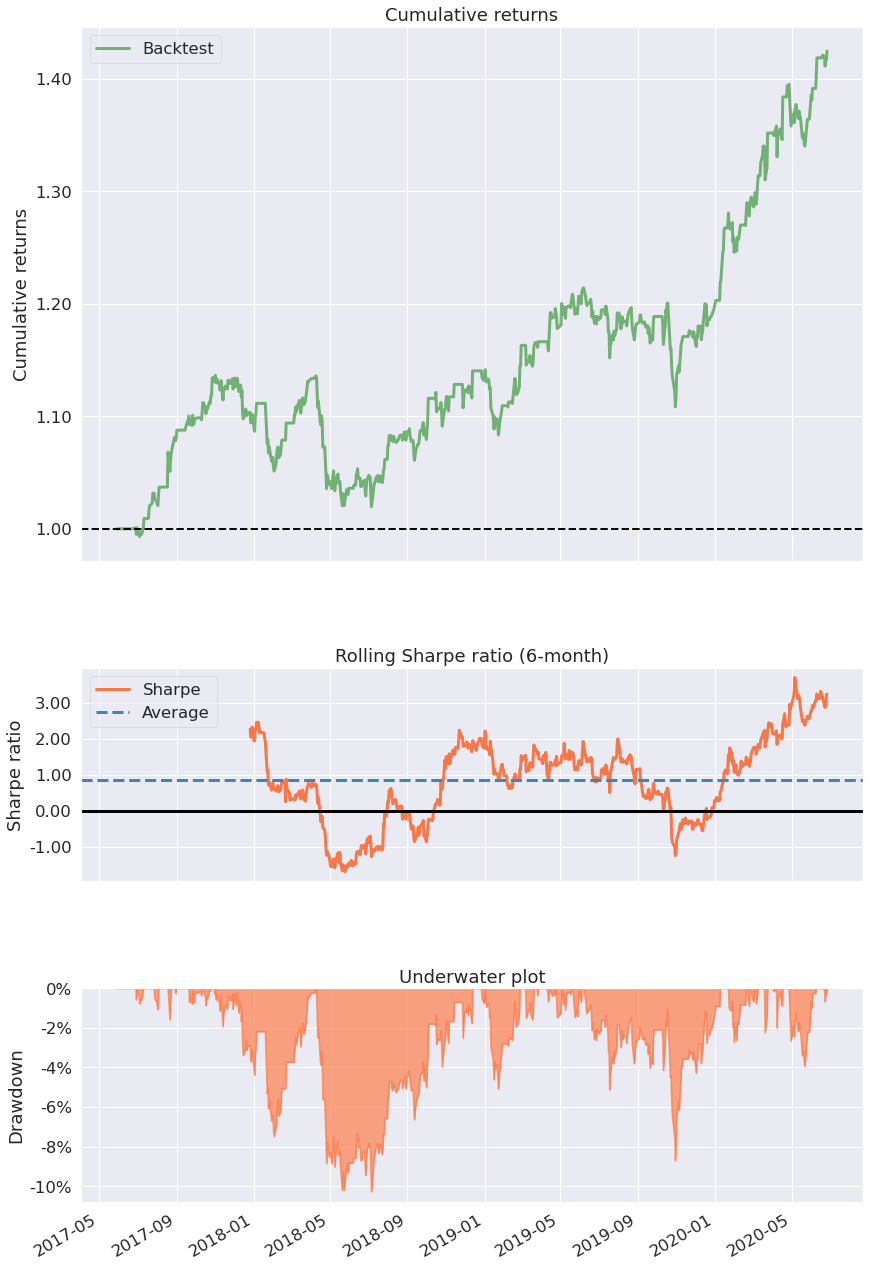

In [22]:
pf.create_simple_tear_sheet(df['strategy_returns'])

In [23]:
#Automobile Stocks

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import yfinance as yf
import pyfolio as pf
start = dt.datetime(2017,5,29).date()
end = dt.datetime(2020,6,29).date()

tickers=['MARUTI.NS', 'HEROMOTOCO.NS', 'M&M.NS']

DF =pd.DataFrame()

for i in tickers:
    df = yf.download(i,start,end)[['Adj Close']]
    df.columns = [i]                         
    DF = pd.concat([DF,df],axis =1)

df = DF.copy().round(5)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MARUTI.NS,HEROMOTOCO.NS,M&M.NS
Date,,,
2017-05-29,6783.73828,3222.96558,656.17133
2017-05-30,6796.14600,3288.51001,656.67798
2017-05-31,6856.52441,3292.99390,683.62341
2017-06-01,6795.29053,3282.35571,687.62787
2017-06-02,6764.95801,3384.69458,684.37122


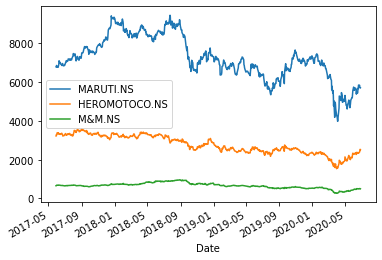

In [25]:
df = df.dropna()
df.plot()
plt.show()

In [26]:
from statsmodels.api import OLS
model = OLS(df['MARUTI.NS'].iloc[:90],df[['HEROMOTOCO.NS','M&M.NS']].iloc[:90])
model = model.fit()
print('The hedge ratio for Maruti, Heromotoco and M&M is')
model.params

The hedge ratio for Maruti, Heromotoco and M&M is


HEROMOTOCO.NS    2.687318
M&M.NS          -2.778612
dtype: float64

In [27]:
df['spread'] = df['MARUTI.NS'] - model.params[0] * df['HEROMOTOCO.NS'] - model.params[1] * df['M&M.NS']
print(df['spread'])

Date
2017-05-29    -54.148284
2017-05-30   -216.471480
2017-05-31    -93.271811
2017-06-01   -114.790655
2017-06-02   -429.189188
                 ...    
2020-06-22    807.369833
2020-06-23    830.166860
2020-06-24    497.961653
2020-06-25    307.187123
2020-06-26    334.860579
Name: spread, Length: 757, dtype: float64


The spread is: Maruti - 2.687318 * Heromotoco - -2.778612 * M&M


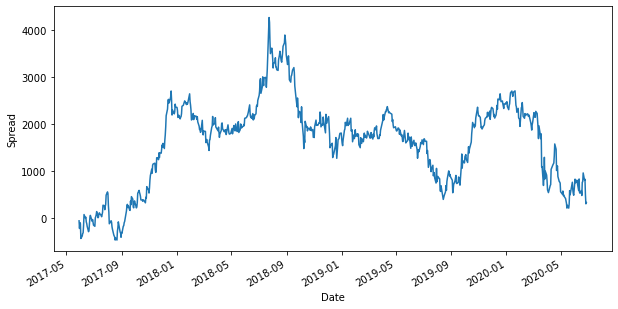

In [28]:
print('The spread is: Maruti - %f * Heromotoco - %f * M&M' %
      (model.params[0], model.params[1]))
# Plot the spread
df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

In [29]:
#To perform ADF Test
from statsmodels.tsa.stattools import adfuller
#Compute ADF Test statistics
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-2.226749335554788

In [30]:
adf[4]

{'1%': -3.439029421541435,
 '5%': -2.8653706489231876,
 '10%': -2.568809835460933}

In [31]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [32]:
df = stat_arb(df, 20, 1)

In [33]:
df['percentage_change'] = (df.spread - df.spread.shift(1)) / (model.params[0] * df['HEROMOTOCO.NS'].shift() + model.params[1] * df['M&M.NS'].shift() + df['MARUTI.NS'].shift())
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
print("The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100))

print((df['strategy_returns'] + 1).cumprod())

The total strategy returns are 6.14
Date
2017-05-29         NaN
2017-05-30         NaN
2017-05-31         NaN
2017-06-01         NaN
2017-06-02         NaN
                ...   
2020-06-22    1.047803
2020-06-23    1.045607
2020-06-24    1.077657
2020-06-25    1.058813
2020-06-26    1.061450
Name: strategy_returns, Length: 757, dtype: float64


Text(0, 0.5, 'Cumulative Returns')

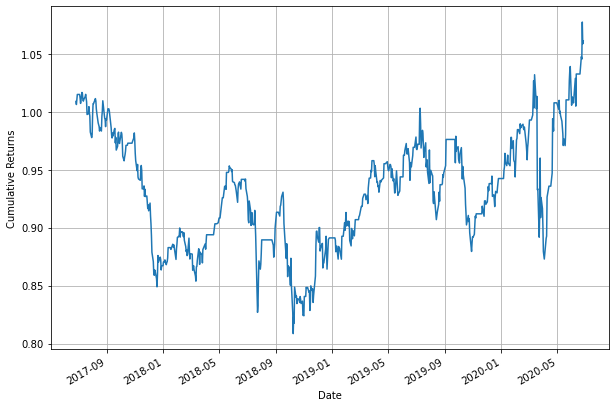

In [34]:
df['cumulative_returns'].plot(figsize=(10, 7), grid=True)
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns') 

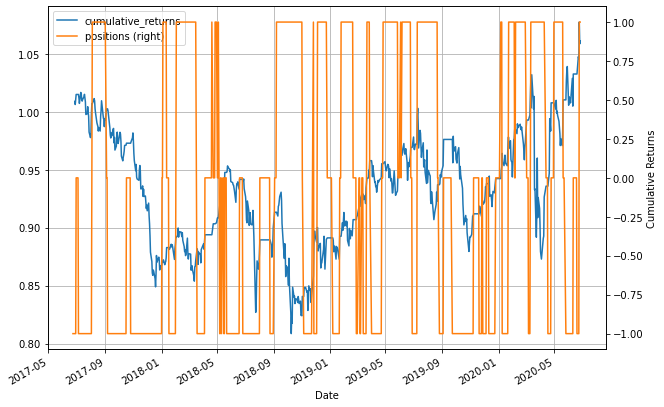

In [35]:
df[['cumulative_returns', 'positions']].plot(
        secondary_y='positions', grid=True, figsize=(10, 7))
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

Date
2017-06-27    1.009137
2017-06-28    1.009137
2017-06-29    1.011361
2017-06-30    1.015133
2017-07-03    1.015133
                ...   
2020-06-22    1.047803
2020-06-23    1.047803
2020-06-24    1.077657
2020-06-25    1.077657
2020-06-26    1.077657
Name: cumulative_returns, Length: 737, dtype: float64
The maximum drawdown is -20.48


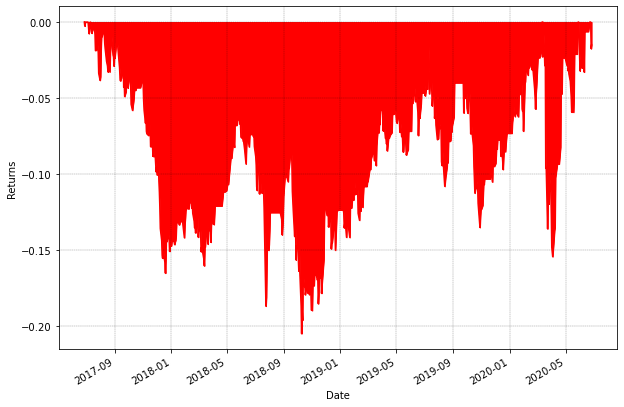

In [36]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

In [37]:
def calc_drawdown_a(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown_a =  1 - (cum_rets)/running_max
    return drawdown_a

drawdown_a = calc_drawdown_a(df.cumulative_returns)


Date
2017-06-27    1.009137
2017-06-28    1.009137
2017-06-29    1.011361
2017-06-30    1.015133
2017-07-03    1.015133
                ...   
2020-06-22    1.047803
2020-06-23    1.047803
2020-06-24    1.077657
2020-06-25    1.077657
2020-06-26    1.077657
Name: cumulative_returns, Length: 737, dtype: float64


In [38]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio is %.2f' % s

'The Sharpe Ratio is 0.21'

In [39]:
Sortino = (df['strategy_returns'].mean()/df['strategy_returns'][df['strategy_returns']<0].std())*np.sqrt(252)
'The Sortino Ratio is %.2f' % Sortino

'The Sortino Ratio is 0.25'

In [40]:
#Average_annual_return = final_equity**(1/years)-1
df.shape[0]
years=df.shape[0]/252
print(years)

3.003968253968254


In [41]:
Average_annual_return = df['cumulative_returns'][-1]**(1/years)-1
Average_annual_return 

0.020050608503010103

In [42]:
max_drawdown = drawdown_a.max()
max_drawdown

0.2048194329834654

In [43]:
calmar = Average_annual_return / max_drawdown
'The Calmar Ratio is %.2f' % calmar

'The Calmar Ratio is 0.10'

Start date,2017-05-29
End date,2020-06-26
Total months,36
,Backtest
Annual return,2.0%
Cumulative returns,6.1%
Annual volatility,16.9%
Sharpe ratio,0.21
Calmar ratio,0.10
Stability,0.05
Max drawdown,-20.5%


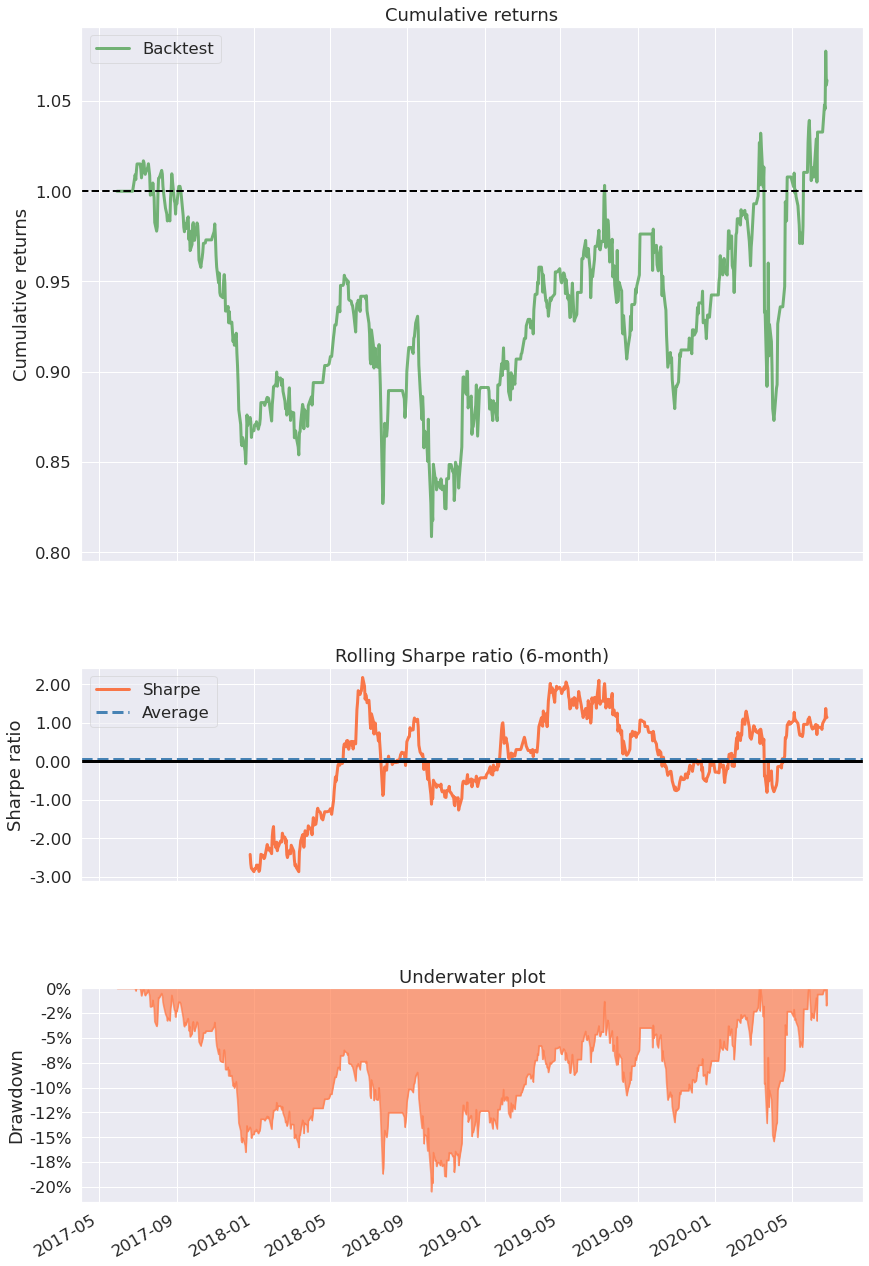

In [44]:
pf.create_simple_tear_sheet(df['strategy_returns'])

In [45]:
#Finance (Private Bank Stocks)

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import yfinance as yf
import pyfolio as pf
start = dt.datetime(2017,5,29).date()
end = dt.datetime(2020,6,29).date()

tickers=['HDFCBANK.NS', 'KOTAKBANK.NS', 'ICICIBANK.NS']

DF =pd.DataFrame()

for i in tickers:
    df = yf.download(i,start,end)[['Adj Close']]
    df.columns = [i]                         
    DF = pd.concat([DF,df],axis =1)

df = DF.copy().round(5)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,HDFCBANK.NS,KOTAKBANK.NS,ICICIBANK.NS
Date,,,
2017-05-29,798.66724,966.92883,278.29095
2017-05-30,797.27240,960.33990,284.03519
2017-05-31,800.77161,964.43298,288.49817
2017-06-01,797.05212,961.03876,282.88635
2017-06-02,799.81720,963.63434,281.16306


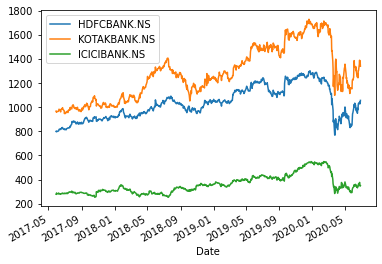

In [47]:
df = df.dropna()
df.plot()
plt.show()

In [48]:
from statsmodels.api import OLS
model = OLS(df['HDFCBANK.NS'].iloc[:90],df[['KOTAKBANK.NS','ICICIBANK.NS']].iloc[:90])
model = model.fit()
print('The hedge ratio for HDFC, KOTAK and ICICI is')
model.params

The hedge ratio for HDFC, KOTAK and ICICI is


KOTAKBANK.NS    0.982314
ICICIBANK.NS   -0.401204
dtype: float64

In [49]:
df['spread'] = df['HDFCBANK.NS'] - model.params[0] * df['KOTAKBANK.NS'] - model.params[1] * df['ICICIBANK.NS']
print(df['spread'])

Date
2017-05-29    -39.509170
2017-05-30    -32.127001
2017-05-31    -30.857916
2017-06-01    -33.494700
2017-06-02    -33.970685
                 ...    
2020-06-22   -155.166905
2020-06-23   -172.105493
2020-06-24   -147.972854
2020-06-25   -187.690770
2020-06-26   -119.888868
Name: spread, Length: 757, dtype: float64


The spread is: HDFC - 0.982314 * KOTAK - -0.401204 * ICICI


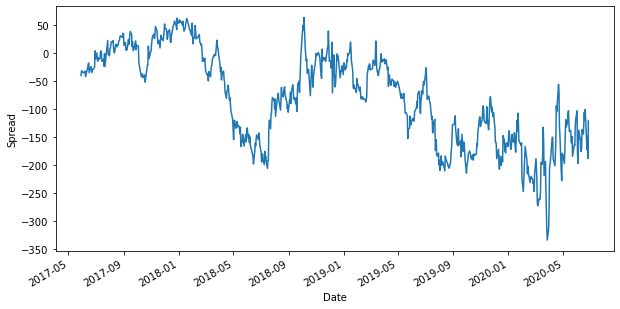

In [50]:
print('The spread is: HDFC - %f * KOTAK - %f * ICICI' %
      (model.params[0], model.params[1]))
# Plot the spread
df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

In [51]:
#To perform ADF Test
from statsmodels.tsa.stattools import adfuller
#Compute ADF Test statistics
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-2.7996229960548185

In [52]:
adf[4]

{'1%': -3.4390409569041207,
 '5%': -2.865375732701395,
 '10%': -2.568812543748081}

In [53]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [54]:
df = stat_arb(df, 20, 1)

In [55]:
df['percentage_change'] = (df.spread - df.spread.shift(1)) / (model.params[0] * df['KOTAKBANK.NS'].shift() + model.params[1] * df['ICICIBANK.NS'].shift() + df['HDFCBANK.NS'].shift())
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
print("The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100))

print((df['strategy_returns'] + 1).cumprod())

The total strategy returns are 77.35
Date
2017-05-29         NaN
2017-05-30         NaN
2017-05-31         NaN
2017-06-01         NaN
2017-06-02         NaN
                ...   
2020-06-22    1.721529
2020-06-23    1.721529
2020-06-24    1.721529
2020-06-25    1.721529
2020-06-26    1.773517
Name: strategy_returns, Length: 757, dtype: float64


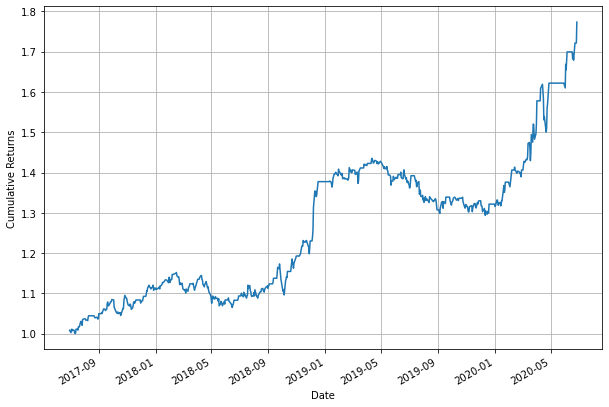

In [56]:
df.cumulative_returns.plot(label='Returns', figsize=(10,7),grid=True)  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

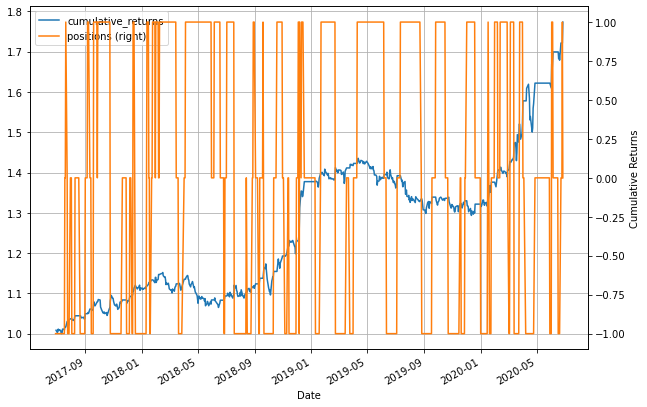

In [57]:
df[['cumulative_returns', 'positions']].plot(
        secondary_y='positions', grid=True, figsize=(10, 7))
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

Date
2017-06-30    1.008503
2017-07-03    1.008503
2017-07-04    1.010078
2017-07-05    1.011296
2017-07-06    1.011296
                ...   
2020-06-22    1.721529
2020-06-23    1.721529
2020-06-24    1.721529
2020-06-25    1.721529
2020-06-26    1.773517
Name: cumulative_returns, Length: 734, dtype: float64
The maximum drawdown is -9.88


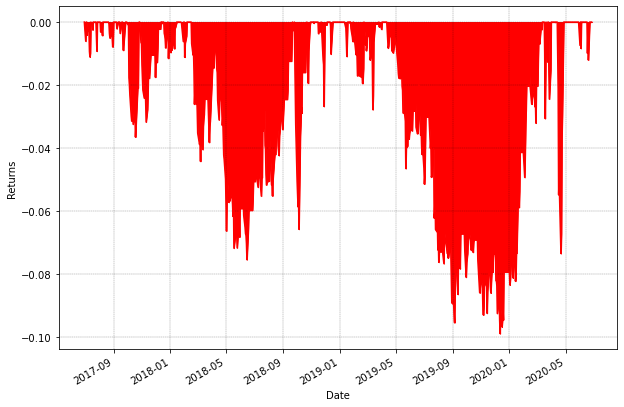

In [58]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

In [59]:
def calc_drawdown_a(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown_a =  1 - (cum_rets)/running_max
    return drawdown_a

drawdown_a = calc_drawdown_a(df.cumulative_returns)


Date
2017-06-30    1.008503
2017-07-03    1.008503
2017-07-04    1.010078
2017-07-05    1.011296
2017-07-06    1.011296
                ...   
2020-06-22    1.721529
2020-06-23    1.721529
2020-06-24    1.721529
2020-06-25    1.721529
2020-06-26    1.773517
Name: cumulative_returns, Length: 734, dtype: float64


In [60]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio is %.2f' % s

'The Sharpe Ratio is 1.72'

In [61]:
Sortino = df['strategy_returns'].mean()/df['strategy_returns'][df['strategy_returns']<0].std()*np.sqrt(252)
'The Sortino Ratio is %.2f' % Sortino

'The Sortino Ratio is 2.74'

In [62]:
#Average_annual_return = final_equity**(1/years)-1
df.shape[0]
years=df.shape[0]/252
print(years)

3.003968253968254


In [63]:
Average_annual_return = df['cumulative_returns'][-1]**(1/years)-1
Average_annual_return 

0.2101397401410363

In [64]:
max_drawdown = drawdown_a.max()
max_drawdown

0.0988225080789834

In [65]:
calmar = Average_annual_return / max_drawdown
'The Calmar Ratio is %.2f' % calmar

'The Calmar Ratio is 2.13'

Start date,2017-05-29
End date,2020-06-26
Total months,36
,Backtest
Annual return,21.0%
Cumulative returns,77.4%
Annual volatility,11.8%
Sharpe ratio,1.72
Calmar ratio,2.13
Stability,0.82
Max drawdown,-9.9%


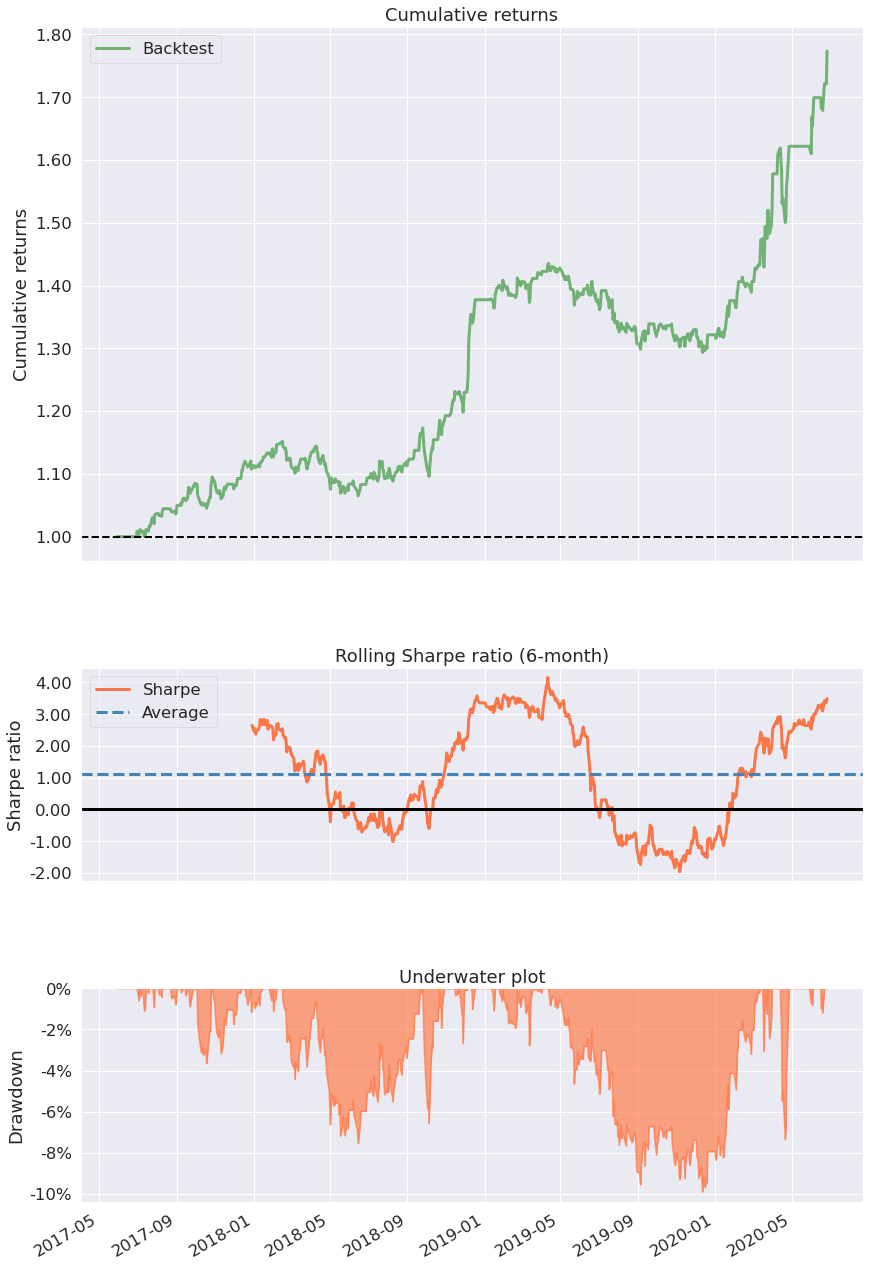

In [66]:
pf.create_simple_tear_sheet(df['strategy_returns'])

In [67]:
#Finance (Financial Services) Stocks

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import yfinance as yf
import pyfolio as pf
start = dt.datetime(2017,5,29).date()
end = dt.datetime(2020,6,29).date()

tickers=['BAJAJFINSV.NS', 'BAJFINANCE.NS', 'MUTHOOTFIN.NS']

DF =pd.DataFrame()

for i in tickers:
    df = yf.download(i,start,end)[['Adj Close']]
    df.columns = [i]                         
    DF = pd.concat([DF,df],axis =1)

df = DF.copy().round(5)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BAJAJFINSV.NS,BAJFINANCE.NS,MUTHOOTFIN.NS
Date,,,
2017-05-29,3991.66016,1296.58899,365.19849
2017-05-30,4147.85986,1310.57178,368.98123
2017-05-31,4185.30029,1315.92688,385.41986
2017-06-01,4198.87842,1316.32373,382.89801
2017-06-02,4298.91846,1349.94202,399.94376


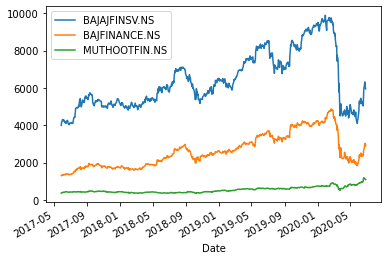

In [69]:
df = df.dropna()
df.plot()
plt.show()

In [70]:
from statsmodels.api import OLS
model = OLS(df['BAJAJFINSV.NS'].iloc[:90],df[['BAJFINANCE.NS','MUTHOOTFIN.NS']].iloc[:90])
model = model.fit()
print('The hedge ratio for BAJAJFINSV, BAJFINANCE and MUTHOOTFIN is')
model.params

The hedge ratio for BAJAJFINSV, BAJFINANCE and MUTHOOTFIN is


BAJFINANCE.NS    2.724095
MUTHOOTFIN.NS    1.027387
dtype: float64

In [71]:
df['spread'] = df['BAJAJFINSV.NS'] - model.params[0] * df['BAJFINANCE.NS'] - model.params[1] * df['MUTHOOTFIN.NS']
print(df['spread'])

Date
2017-05-29      84.428976
2017-05-30     198.651896
2017-05-31     204.615699
2017-06-01     219.703687
2017-06-02     210.651747
                 ...     
2020-06-22   -2742.999109
2020-06-23   -3081.298851
2020-06-24   -3090.894082
2020-06-25   -3300.765031
2020-06-26   -3082.960444
Name: spread, Length: 757, dtype: float64


The spread is: BAJAJFINSV - 2.724095 * BAJFINANCE - 1.027387 * MUTHOOTFIN


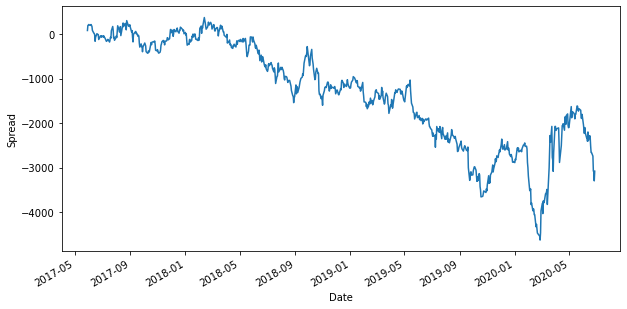

In [72]:
print('The spread is: BAJAJFINSV - %f * BAJFINANCE - %f * MUTHOOTFIN' %
      (model.params[0], model.params[1]))
# Plot the spread
df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

In [73]:
#To perform ADF Test
from statsmodels.tsa.stattools import adfuller
#Compute ADF Test statistics
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-1.2205313869158267

In [74]:
adf[4]

{'1%': -3.439029421541435,
 '5%': -2.8653706489231876,
 '10%': -2.568809835460933}

In [75]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [76]:
df = stat_arb(df, 20, 1)

In [77]:
df['percentage_change'] = (df.spread - df.spread.shift(1)) / (model.params[0] * df['BAJFINANCE.NS'].shift() + model.params[1] * df['MUTHOOTFIN.NS'].shift() + df['BAJAJFINSV.NS'].shift())
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
print("The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100))

print((df['strategy_returns'] + 1).cumprod())

The total strategy returns are -12.67
Date
2017-05-29         NaN
2017-05-30         NaN
2017-05-31         NaN
2017-06-01         NaN
2017-06-02         NaN
                ...   
2020-06-22    0.893681
2020-06-23    0.873672
2020-06-24    0.873139
2020-06-25    0.861070
2020-06-26    0.873293
Name: strategy_returns, Length: 757, dtype: float64


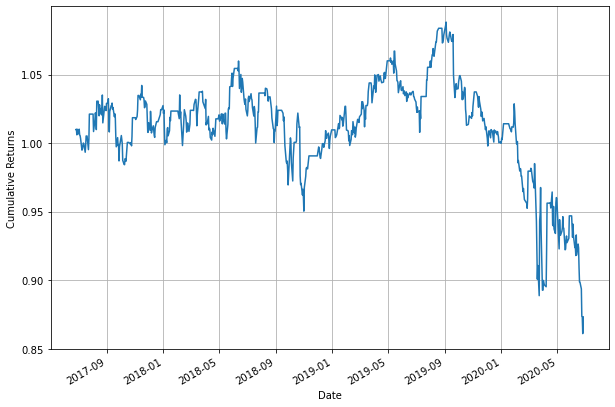

In [78]:
df.cumulative_returns.plot(label='Returns', figsize=(10,7),grid=True)  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

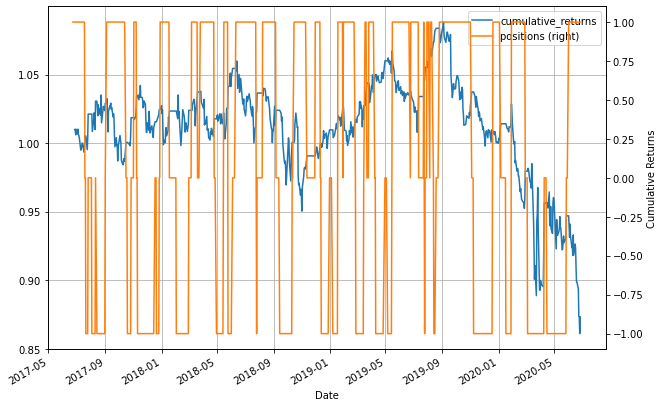

In [79]:
df[['cumulative_returns', 'positions']].plot(
        secondary_y='positions', grid=True, figsize=(10, 7))
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

Date
2017-06-27    1.009959
2017-06-28    1.010181
2017-06-29    1.010181
2017-06-30    1.010181
2017-07-03    1.010181
                ...   
2020-06-22    1.088353
2020-06-23    1.088353
2020-06-24    1.088353
2020-06-25    1.088353
2020-06-26    1.088353
Name: cumulative_returns, Length: 737, dtype: float64
The maximum drawdown is -20.88


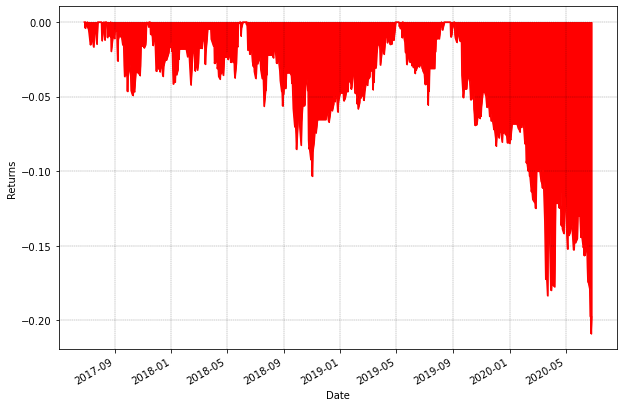

In [80]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

In [81]:
def calc_drawdown_a(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown_a =  1 - (cum_rets)/running_max
    return drawdown_a

drawdown_a = calc_drawdown_a(df.cumulative_returns)


Date
2017-06-27    1.009959
2017-06-28    1.010181
2017-06-29    1.010181
2017-06-30    1.010181
2017-07-03    1.010181
                ...   
2020-06-22    1.088353
2020-06-23    1.088353
2020-06-24    1.088353
2020-06-25    1.088353
2020-06-26    1.088353
Name: cumulative_returns, Length: 737, dtype: float64


In [82]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio is %.2f' % s

'The Sharpe Ratio is -0.30'

In [83]:
Sortino = df['strategy_returns'].mean()/df['strategy_returns'][df['strategy_returns']<0].std()*np.sqrt(252)
'The Sortino Ratio is %.2f' % Sortino

'The Sortino Ratio is -0.38'

In [84]:
#Average_annual_return = final_equity**(1/years)-1
df.shape[0]
years=df.shape[0]/252
print(years)

3.003968253968254


In [85]:
Average_annual_return = df['cumulative_returns'][-1]**(1/years)-1
Average_annual_return 

-0.04409960464279805

In [86]:
max_drawdown = drawdown_a.max()
max_drawdown

0.20883242221038212

In [87]:
calmar = Average_annual_return / max_drawdown
'The Calmar Ratio is %.2f' % calmar

'The Calmar Ratio is -0.21'

Start date,2017-05-29
End date,2020-06-26
Total months,36
,Backtest
Annual return,-4.4%
Cumulative returns,-12.7%
Annual volatility,12.7%
Sharpe ratio,-0.30
Calmar ratio,-0.21
Stability,0.11
Max drawdown,-20.9%


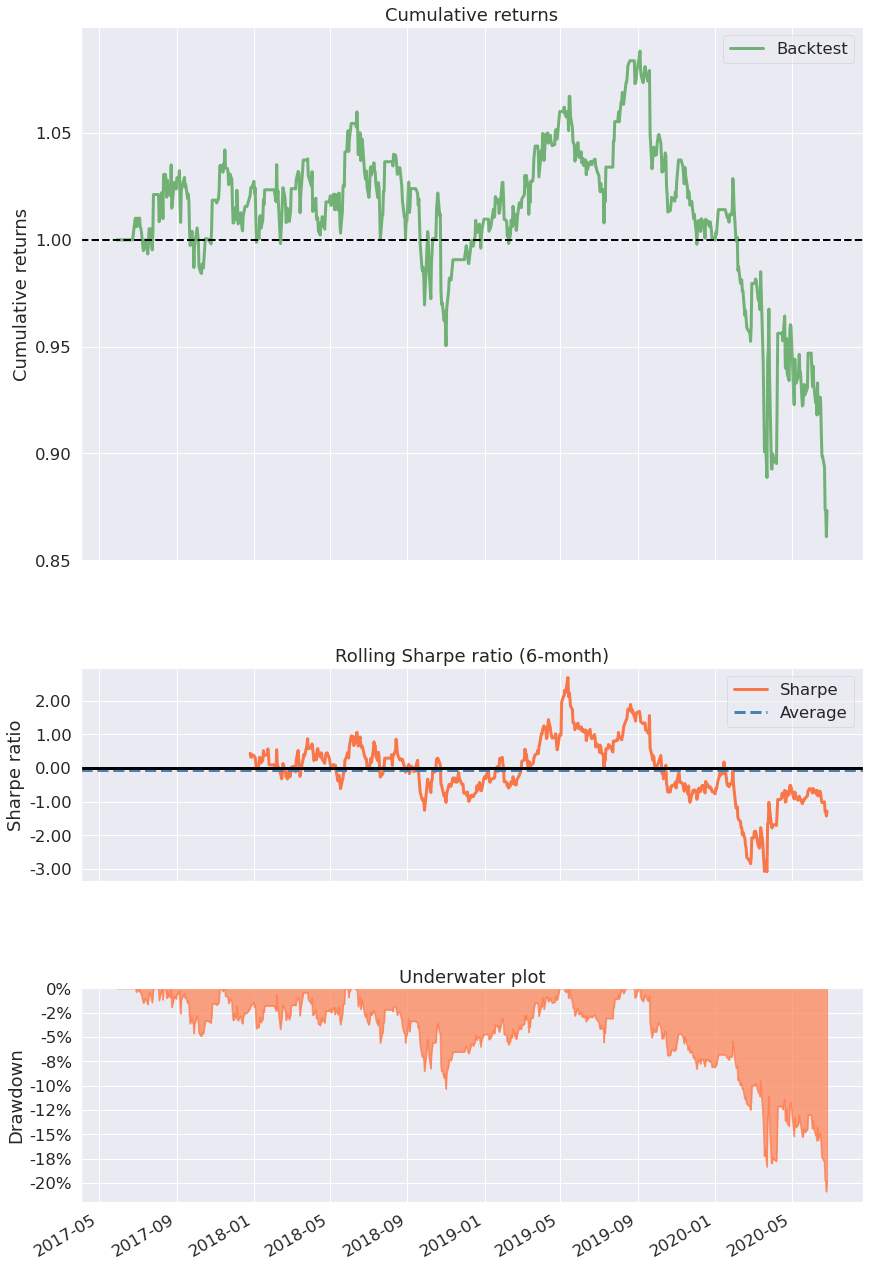

In [88]:
pf.create_simple_tear_sheet(df['strategy_returns'])

In [89]:
#Pharmaceutical Stocks

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import yfinance as yf
import pyfolio as pf
start = dt.datetime(2017,5,29).date()
end = dt.datetime(2020,6,29).date()

tickers=['PFIZER.NS', 'ASTRAZEN.NS', 'GLAXO.NS']

DF =pd.DataFrame()

for i in tickers:
    df = yf.download(i,start,end)[['Adj Close']]
    df.columns = [i]                         
    DF = pd.concat([DF,df],axis =1)

df = DF.copy().round(5)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,PFIZER.NS,ASTRAZEN.NS,GLAXO.NS
Date,,,
2017-05-29,1519.32300,924.91602,1057.61475
2017-05-30,1514.72705,923.06818,1084.63892
2017-05-31,1531.59412,928.46185,1102.83643
2017-06-01,1578.74841,935.05414,1117.87988
2017-06-02,1551.72424,933.95544,1119.71790


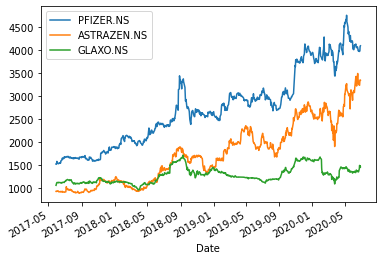

In [91]:
df = df.dropna()
df.plot()
plt.show()

In [92]:
from statsmodels.api import OLS
model = OLS(df['PFIZER.NS'].iloc[:90],df[['ASTRAZEN.NS','GLAXO.NS']].iloc[:90])
model = model.fit()
print('The hedge ratio for PFIZER, ASTRAZEN and GLAXO is')
model.params

The hedge ratio for PFIZER, ASTRAZEN and GLAXO is


ASTRAZEN.NS    0.100007
GLAXO.NS       1.374321
dtype: float64

In [93]:
df['spread'] = df['PFIZER.NS'] - model.params[0] * df['ASTRAZEN.NS'] - model.params[1] * df['GLAXO.NS']
print(df['spread'])

Date
2017-05-29     -26.677536
2017-05-30     -68.228569
2017-05-31     -76.910124
2017-06-01     -51.089640
2017-06-02     -80.529961
                 ...     
2020-06-22    1695.032239
2020-06-23    1610.385128
2020-06-24    1663.735775
2020-06-25    1714.792768
2020-06-26    1749.460956
Name: spread, Length: 757, dtype: float64


The spread is: PFIZER - 0.100007 * ASTRAZEN - 1.374321 * GLAXO


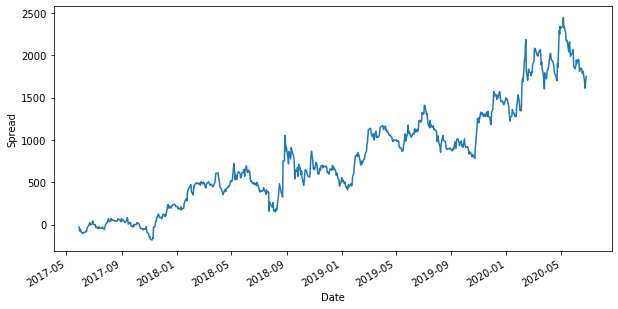

In [94]:
print('The spread is: PFIZER - %f * ASTRAZEN - %f * GLAXO' %
      (model.params[0], model.params[1]))
# Plot the spread
df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

In [95]:
#To perform ADF Test
from statsmodels.tsa.stattools import adfuller
#Compute ADF Test statistics
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-1.161461062225937

In [96]:
adf[4]

{'1%': -3.439029421541435,
 '5%': -2.8653706489231876,
 '10%': -2.568809835460933}

In [97]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [98]:
df = stat_arb(df, 20, 1)

In [99]:
df['percentage_change'] = (df.spread - df.spread.shift(1)) / (model.params[0] * df['ASTRAZEN.NS'].shift() + model.params[1] * df['GLAXO.NS'].shift() + df['PFIZER.NS'].shift())
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
print("The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100))

print((df['strategy_returns'] + 1).cumprod())

The total strategy returns are -19.70
Date
2017-05-29         NaN
2017-05-30         NaN
2017-05-31         NaN
2017-06-01         NaN
2017-06-02         NaN
                ...   
2020-06-22    0.796469
2020-06-23    0.785670
2020-06-24    0.792263
2020-06-25    0.798683
2020-06-26    0.802971
Name: strategy_returns, Length: 757, dtype: float64


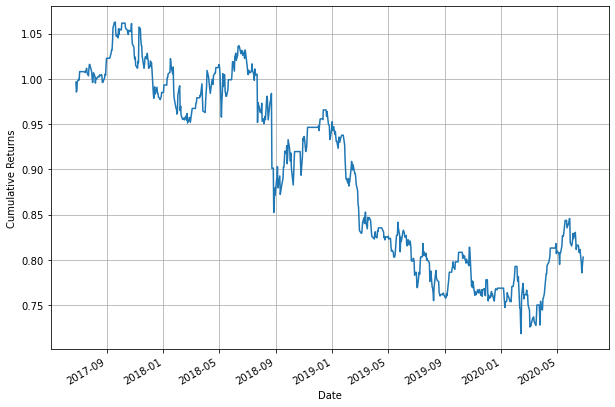

In [100]:
df.cumulative_returns.plot(label='Returns', figsize=(10,7),grid=True)  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

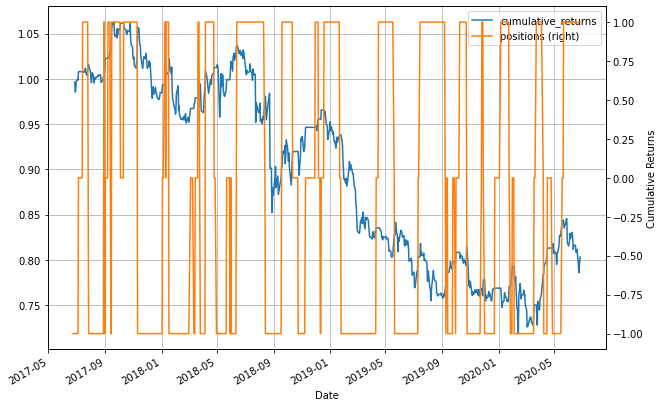

In [101]:
df[['cumulative_returns', 'positions']].plot(
        secondary_y='positions', grid=True, figsize=(10, 7))
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

Date
2017-06-27    0.996427
2017-06-28    0.996427
2017-06-29    0.996427
2017-06-30    0.997239
2017-07-03    0.999634
                ...   
2020-06-22    1.062923
2020-06-23    1.062923
2020-06-24    1.062923
2020-06-25    1.062923
2020-06-26    1.062923
Name: cumulative_returns, Length: 737, dtype: float64
The maximum drawdown is -32.41


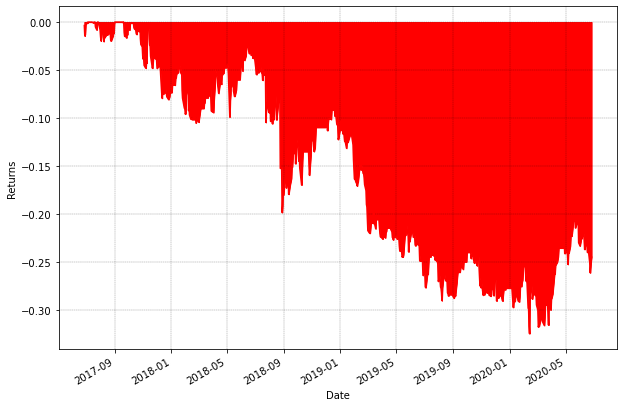

In [102]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

In [103]:
def calc_drawdown_a(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    print(running_max)
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown_a =  1 - (cum_rets)/running_max
    return drawdown_a

drawdown_a = calc_drawdown_a(df.cumulative_returns)



Date
2017-06-27    0.996427
2017-06-28    0.996427
2017-06-29    0.996427
2017-06-30    0.997239
2017-07-03    0.999634
                ...   
2020-06-22    1.062923
2020-06-23    1.062923
2020-06-24    1.062923
2020-06-25    1.062923
2020-06-26    1.062923
Name: cumulative_returns, Length: 737, dtype: float64


In [104]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio %.2f' % s

'The Sharpe Ratio -0.38'

In [105]:
Sortino = df['strategy_returns'].mean()/df['strategy_returns'][df['strategy_returns']<0].std()*np.sqrt(252)
'The Sortino Ratio %.2f' % Sortino

'The Sortino Ratio -0.42'

In [106]:
#Average_annual_return = final_equity**(1/years)-1
df.shape[0]
years=df.shape[0]/252
print(years)

3.003968253968254


In [107]:
Average_annual_return = df['cumulative_returns'][-1]**(1/years)-1
Average_annual_return 

-0.07044467693682643

In [108]:
max_drawdown = drawdown_a.max()
max_drawdown

0.32414416197264484

In [109]:
calmar = Average_annual_return / max_drawdown
'The Calmar Ratio is %.2f' % calmar

'The Calmar Ratio is -0.22'

Start date,2017-05-29
End date,2020-06-26
Total months,36
,Backtest
Annual return,-7.0%
Cumulative returns,-19.7%
Annual volatility,16.4%
Sharpe ratio,-0.38
Calmar ratio,-0.22
Stability,0.84
Max drawdown,-32.4%


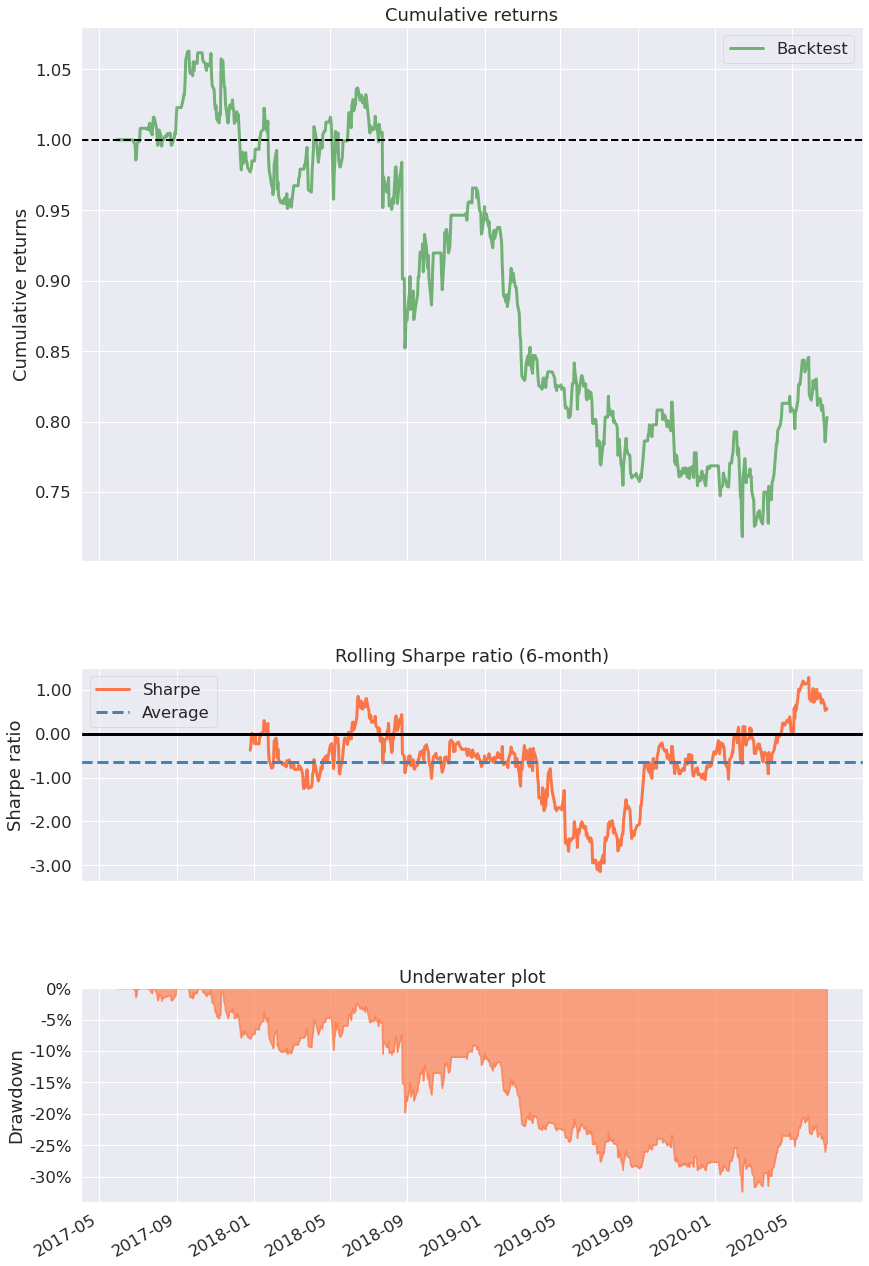

In [110]:
pf.create_simple_tear_sheet(df['strategy_returns'])